<a href="https://colab.research.google.com/github/emiresenov/PRPD-Classification/blob/main/PRPD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys, zipfile, pathlib, random
from pathlib import Path

import numpy as np
import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

SEED = 42
tf.keras.utils.set_random_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)


TensorFlow: 2.19.0
GPU available: True


# Data collection and processing

In [2]:
ZIP_URL = "https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/xz4xhrc4yr-7.zip"

DATA_DIR = Path("/content")
ZIP_PATH = DATA_DIR / "pd.zip"
RAW_DIR = DATA_DIR / "pd_raw"

!wget -q -O "$ZIP_PATH" "$ZIP_URL"

RAW_DIR.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(RAW_DIR)

for p in list(RAW_DIR.glob("*"))[:10]:
    print(p)


/content/pd_raw/Images of resolved phase patterns of partial discharges in electric generators


In [3]:
IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

LABEL_CANON = {
    "internal": "internal",
    "corona": "corona",
    "surface": "surface",
    "superficial": "surface",
}

def find_label_from_path(path: Path):
    for part in reversed(path.parts):
        key = part.lower()
        if key in LABEL_CANON:
            return LABEL_CANON[key]
    lower = [p.lower() for p in path.parts]
    for key in LABEL_CANON:
        if any(key in seg for seg in lower):
            return LABEL_CANON[key]
    return None

all_imgs = []
for p in RAW_DIR.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        lbl = find_label_from_path(p.parent)
        if lbl is not None:
            all_imgs.append((str(p), lbl))

print(f"Found {len(all_imgs)} labeled images.")
labels = sorted(set(lbl for _, lbl in all_imgs))
print("Labels:", labels)

from collections import Counter
cnt = Counter(lbl for _, lbl in all_imgs)
print("Per-class counts:", cnt)

assert len(labels) >= 2, "Did not detect at least two classes. Check extracted folders."


Found 945 labeled images.
Labels: ['corona', 'internal', 'surface']
Per-class counts: Counter({'internal': 321, 'surface': 316, 'corona': 308})


In [4]:
from sklearn.model_selection import train_test_split

paths = np.array([p for p, _ in all_imgs])
y_text = np.array([lbl for _, lbl in all_imgs])

label_to_id = {lbl:i for i, lbl in enumerate(sorted(set(y_text)))}
id_to_label = {i:lbl for lbl, i in label_to_id.items()}
y = np.array([label_to_id[lbl] for lbl in y_text])

X_train, X_tmp, y_train, y_tmp = train_test_split(
    paths, y, test_size=0.30, random_state=SEED, stratify=y
)
X_test, X_val, y_test, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.5, random_state=SEED, stratify=y_tmp
)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
print("Classes:", id_to_label)


Train: 661, Val: 142, Test: 142
Classes: {0: np.str_('corona'), 1: np.str_('internal'), 2: np.str_('surface')}


In [5]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)
BATCH = 32

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE, antialias=True)
    img.set_shape((*IMG_SIZE, 3))
    return img, label

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(len(paths), seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(X_train, y_train, training=True)
val_ds   = make_ds(X_val,   y_val,   training=False)
test_ds  = make_ds(X_test,  y_test,  training=False)


# Baseline model

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

num_classes = len(label_to_id)

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

baseline_model = keras.Model(inputs, outputs)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
baseline_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,635 (365.76 KB)

 Trainable params: 93,635 (365.76 KB)

 Non-trainable params: 0 (0.00 B)

## Train model

In [7]:
val_ds  = val_ds.cache()
test_ds = test_ds.cache()

history = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 17s 494ms/step - accuracy: 0.3931 - loss: 1.0595 - val_accuracy: 0.5000 - val_loss: 1.0199
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 244ms/step - accuracy: 0.4412 - loss: 1.0042 - val_accuracy: 0.5070 - val_loss: 0.9159
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - accuracy: 0.5324 - loss: 0.8876 - val_accuracy: 0.6056 - val_loss: 0.8405
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 289ms/step - accuracy: 0.6301 - loss: 0.8239 - val_accuracy: 0.6972 - val_loss: 0.7938
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.6587 - loss: 0.7670 - val_accuracy: 0.7465 - val_loss: 0.6739
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - accuracy: 0.7289 - loss: 0.6587 - val_accuracy: 0.7676 - val_loss: 0.6319
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.7071 - loss: 0.6268 - val_accuracy: 0.7465 - val_loss: 0.6385
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.6890 - loss: 0.6482 - val_accuracy: 0

## Plot baseline model results

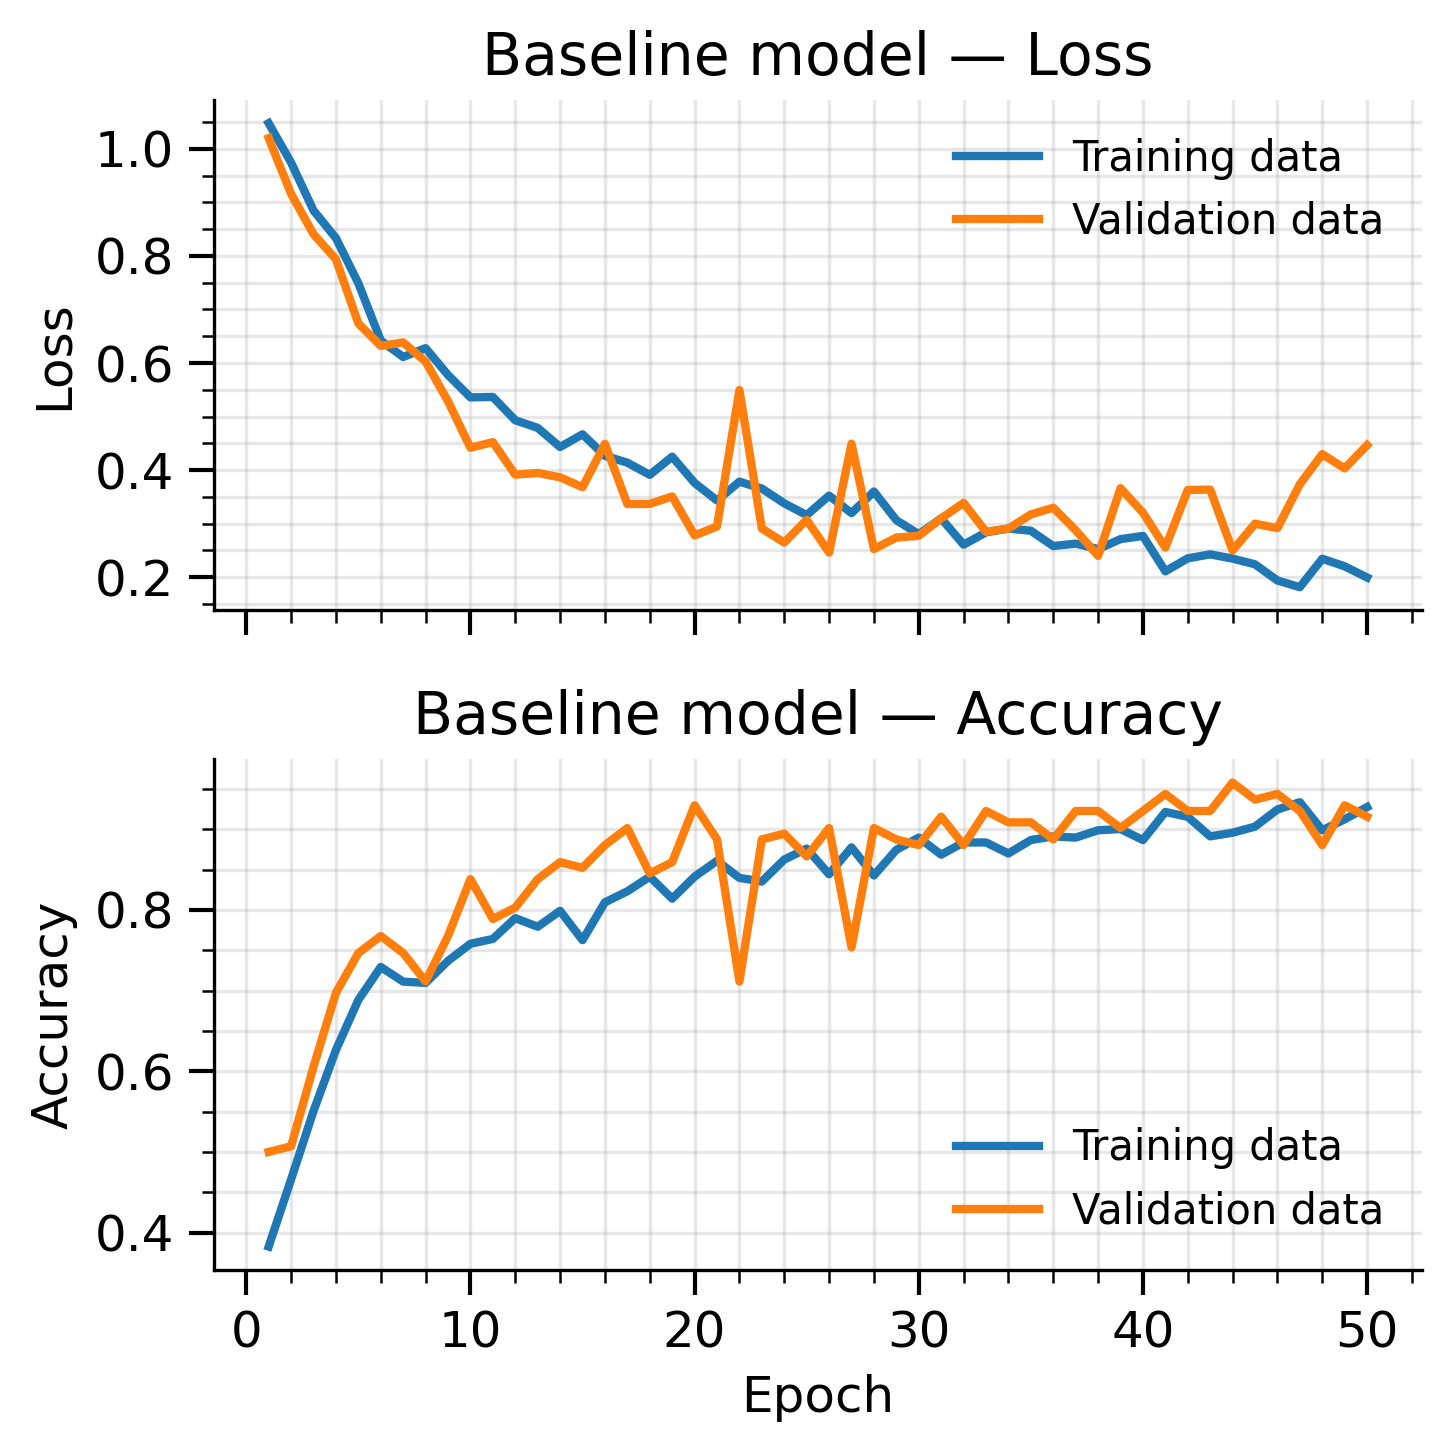

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 14,
    "legend.fontsize": 10,
    "lines.linewidth": 2.0,
    "figure.dpi": 300,
})

hist = history.history
epochs = range(1, len(hist["loss"]) + 1)

acc_key = "accuracy" if "accuracy" in hist else "acc"
val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"

def finalize_axes(ax, ylabel, title, xlabel=None):
    if xlabel:
        ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, which="both", alpha=0.3)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.tick_params(direction="out", length=6, width=1)
    ax.tick_params(which="minor", length=3)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend(frameon=False)


fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)


axes[0].plot(epochs, hist["loss"], label="Training data")
axes[0].plot(epochs, hist["val_loss"], label="Validation data")
finalize_axes(axes[0], ylabel="Loss", title="Baseline model — Loss")

axes[1].plot(epochs, hist[acc_key], label="Training data")
axes[1].plot(epochs, hist[val_acc_key], label="Validation data")
finalize_axes(axes[1], ylabel="Accuracy", title="Baseline model — Accuracy", xlabel="Epoch")

plt.tight_layout()
fig.savefig("baseline_combined.pdf", bbox_inches="tight")
plt.show()


## Save model

In [9]:
baseline_model.save("baseline_model.keras")

# Ablation

## Utility functions and baseline metrics

In [10]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

AUTOTUNE = tf.data.AUTOTUNE
val_ds  = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

id_to_label = {v: k for k, v in label_to_id.items()}
class_names = [id_to_label[i] for i in range(len(label_to_id))]
num_classes = len(label_to_id)

def y_true_from_ds(ds):
    ys = []
    for _, y in ds:
        ys.append(y.numpy())
    return np.concatenate(ys, axis=0)

def evaluate_model(model, ds):
    """Return accuracy + macro/micro precision/recall/F1 on ds."""
    y_true = y_true_from_ds(ds)
    y_prob = model.predict(ds, verbose=0)
    y_pred = np.argmax(y_prob, axis=1)

    acc = accuracy_score(y_true, y_pred)
    p_mac, r_mac, f_mac, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )
    p_mic, r_mic, f_mic, _ = precision_recall_fscore_support(
        y_true, y_pred, average="micro", zero_division=0
    )
    return {
        "accuracy": acc,
        "precision_macro": p_mac, "recall_macro": r_mac, "f1_macro": f_mac,
        "precision_micro": p_mic, "recall_micro": r_mic, "f1_micro": f_mic,
    }

def compile_baseline():
    """Rebuilds the baseline architecture (used by some ablations)."""
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x); x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    return model

baseline_model = keras.models.load_model("baseline_model.keras")
baseline_val_metrics  = evaluate_model(baseline_model, val_ds)
baseline_test_metrics = evaluate_model(baseline_model, test_ds)

print("Baseline (saved model) — VAL:", baseline_val_metrics)
print("Baseline (saved model) — TEST:", baseline_test_metrics)

Baseline (saved model) — VAL: {'accuracy': 0.9154929577464789, 'precision_macro': 0.9276315789473685, 'recall_macro': 0.9165189125295509, 'f1_macro': 0.9142851472572834, 'precision_micro': 0.9154929577464789, 'recall_micro': 0.9154929577464789, 'f1_micro': 0.9154929577464789}
Baseline (saved model) — TEST: {'accuracy': 0.8450704225352113, 'precision_macro': 0.8787785947712418, 'recall_macro': 0.8472222222222222, 'f1_macro': 0.8359131075110456, 'precision_micro': 0.8450704225352113, 'recall_micro': 0.8450704225352113, 'f1_micro': 0.8450704225352113}


## Batchnorm after each Conv

In [11]:
def build_bn_model():
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(32, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.ReLU()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

bn_model = build_bn_model()
history_bn = bn_model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)
bn_model.save("ablation_bn.keras")

bn_val_metrics  = evaluate_model(bn_model, val_ds)
bn_test_metrics = evaluate_model(bn_model, test_ds)
print("BN — VAL:", bn_val_metrics)
print("BN — TEST:", bn_test_metrics)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 14s 422ms/step - accuracy: 0.6167 - loss: 0.8492 - val_accuracy: 0.5282 - val_loss: 1.1085
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.7697 - loss: 0.5781 - val_accuracy: 0.3592 - val_loss: 1.2188
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - accuracy: 0.7886 - loss: 0.5045 - val_accuracy: 0.5423 - val_loss: 1.2909
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.8216 - loss: 0.4819 - val_accuracy: 0.5423 - val_loss: 1.4640
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 193ms/step - accuracy: 0.8137 - loss: 0.4804 - val_accuracy: 0.5000 - val_loss: 1.4432
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 243ms/step - accuracy: 0.8425 - loss: 0.4217 - val_accuracy: 0.3380 - val_loss: 1.6665
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.8780 - loss: 0.3715 - val_accuracy: 0.3380 - val_loss: 1.8906
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.8698 - loss: 0.3604 - val_accuracy: 0

## AdamW with weight_decay=1e-4

In [12]:
def build_baseline_adamw():
    model = compile_baseline()
    opt = keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)
    model.compile(optimizer=opt,
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

adamw_model = build_baseline_adamw()
history_adamw = adamw_model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)
adamw_model.save("ablation_adamw.keras")

adamw_val_metrics  = evaluate_model(adamw_model, val_ds)
adamw_test_metrics = evaluate_model(adamw_model, test_ds)
print("AdamW — VAL:", adamw_val_metrics)
print("AdamW — TEST:", adamw_test_metrics)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.2979 - loss: 1.0679 - val_accuracy: 0.3592 - val_loss: 1.0566
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 241ms/step - accuracy: 0.4839 - loss: 0.9928 - val_accuracy: 0.6549 - val_loss: 0.9440
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.6600 - loss: 0.8665 - val_accuracy: 0.5704 - val_loss: 0.9242
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 194ms/step - accuracy: 0.6381 - loss: 0.8021 - val_accuracy: 0.7113 - val_loss: 0.8216
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.7075 - loss: 0.7039 - val_accuracy: 0.7183 - val_loss: 0.7561
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.6932 - loss: 0.7058 - val_accuracy: 0.7113 - val_loss: 0.7209
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.7330 - loss: 0.6378 - val_accuracy: 0.7183 - val_loss: 0.6936
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.7409 - loss: 0.5734 - val_accuracy: 0

## Label smoothing (eps=0.1)

In [16]:
def build_baseline_ls():
    model = compile_baseline()

    # Manual label smoothing implementation
    def smooth_loss(y_true, y_pred):
        num_classes = tf.cast(tf.shape(y_pred)[-1], tf.float32)
        y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
        smooth_positives = 1.0 - 0.1   # epsilon = 0.1
        smooth_negatives = 0.1 / num_classes
        y_true_ls = y_true_one_hot * smooth_positives + smooth_negatives

        loss = -tf.reduce_sum(y_true_ls * tf.math.log(y_pred + 1e-7), axis=-1)
        return tf.reduce_mean(loss)

    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss=smooth_loss,
        metrics=["accuracy"],
    )
    return model


ls_model = build_baseline_ls()
history_ls = ls_model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)
ls_model.save("ablation_labelsmooth.keras")

ls_val_metrics  = evaluate_model(ls_model, val_ds)
ls_test_metrics = evaluate_model(ls_model, test_ds)
print("Label Smoothing — VAL:", ls_val_metrics)
print("Label Smoothing — TEST:", ls_test_metrics)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.3547 - loss: 1.0607 - val_accuracy: 0.5352 - val_loss: 1.0410
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.5203 - loss: 1.0043 - val_accuracy: 0.6831 - val_loss: 0.9610
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.6131 - loss: 0.9012 - val_accuracy: 0.6972 - val_loss: 0.8920
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.7026 - loss: 0.8275 - val_accuracy: 0.7394 - val_loss: 0.7995
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 240ms/step - accuracy: 0.7113 - loss: 0.7680 - val_accuracy: 0.7183 - val_loss: 0.7843
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.6811 - loss: 0.7680 - val_accuracy: 0.7394 - val_loss: 0.7501
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 186ms/step - accuracy: 0.7580 - loss: 0.7083 - val_accuracy: 0.7958 - val_loss: 0.7037
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.7432 - loss: 0.7048 - val_accuracy: 0

In [13]:
def build_deeper_model():
    inputs = keras.Input(shape=(*IMG_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(32, 3, padding="same", activation="relu")(x);  x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(x);  x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)  # +1 block
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

deep_model = build_deeper_model()
history_deep = deep_model.fit(train_ds, validation_data=val_ds, epochs=50, verbose=1)
deep_model.save("ablation_deeper.keras")

deep_val_metrics  = evaluate_model(deep_model, val_ds)
deep_test_metrics = evaluate_model(deep_model, test_ds)
print("Deeper — VAL:", deep_val_metrics)
print("Deeper — TEST:", deep_test_metrics)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 565ms/step - accuracy: 0.3039 - loss: 1.0633 - val_accuracy: 0.6620 - val_loss: 0.9747
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.6013 - loss: 0.9060 - val_accuracy: 0.7113 - val_loss: 0.8178
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.7436 - loss: 0.6241 - val_accuracy: 0.7535 - val_loss: 0.6128
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.7392 - loss: 0.5744 - val_accuracy: 0.7817 - val_loss: 0.5103
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.7402 - loss: 0.5499 - val_accuracy: 0.7958 - val_loss: 0.4868
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.7899 - loss: 0.4675 - val_accuracy: 0.8662 - val_loss: 0.3930
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.8106 - loss: 0.4299 - val_accuracy: 0.7606 - val_loss: 0.4639
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 196ms/step - accuracy: 0.7495 - loss: 0.4649 - val_accuracy: 0

In [21]:
import pandas as pd

def to_row(name, val, test):
    return {
        "Method": name,
        "Val_Acc": val["accuracy"],
        "Val_F1_macro": val["f1_macro"],
        "Val_Prec_macro": val["precision_macro"],
        "Val_Rec_macro": val["recall_macro"],
        "Test_Acc": test["accuracy"],
        "Test_F1_macro": test["f1_macro"],
        "Test_Prec_macro": test["precision_macro"],
        "Test_Rec_macro": test["recall_macro"]
    }

rows = [
    to_row("Baseline", baseline_val_metrics, baseline_test_metrics),
    to_row("BatchNorm", bn_val_metrics, bn_test_metrics),
    to_row("AdamW (wd=1e-4)", adamw_val_metrics, adamw_test_metrics),
    to_row("Label smoothing (ε=0.1)", ls_val_metrics, ls_test_metrics),
    to_row("Deeper (+1 block)", deep_val_metrics, deep_test_metrics),
]

df = pd.DataFrame(rows)
df_rounded = df.copy()
for c in df.columns:
    if c != "Method":
        df_rounded[c] = df[c].astype(float).round(5)

display(df_rounded)
df_rounded.to_csv("ablations_results.csv", index=False)
print("Saved metrics to ablations_results.csv")

latex_cols = ["Method","Val_Acc","Val_F1_macro","Test_Acc","Test_F1_macro"]
print(df_rounded[latex_cols].to_string(index=False))


,Method,Val_Acc,Val_F1_macro,Val_Prec_macro,Val_Rec_macro,Test_Acc,Test_F1_macro,Test_Prec_macro,Test_Rec_macro
0,Baseline,0.91549,0.91429,0.92763,0.91652,0.84507,0.83591,0.87878,0.84722
1,BatchNorm,0.96479,0.96443,0.96548,0.96469,0.98592,0.98596,0.98596,0.98611
2,AdamW (wd=1e-4),0.95775,0.95755,0.95997,0.95819,0.94366,0.94291,0.94715,0.94414
3,Label smoothing (ε=0.1),0.91549,0.91609,0.92637,0.91593,0.89437,0.89282,0.90473,0.89523
4,Deeper (+1 block),0.97887,0.97887,0.97930,0.97902,0.97887,0.97887,0.97917,0.97917


Saved metrics to ablations_results.csv
                 Method  Val_Acc  Val_F1_macro  Test_Acc  Test_F1_macro
               Baseline  0.91549       0.91429   0.84507        0.83591
              BatchNorm  0.96479       0.96443   0.98592        0.98596
        AdamW (wd=1e-4)  0.95775       0.95755   0.94366        0.94291
Label smoothing (ε=0.1)  0.91549       0.91609   0.89437        0.89282
      Deeper (+1 block)  0.97887       0.97887   0.97887        0.97887


# Transfer Learning with EfficientNetV2-B0

In [22]:
from tensorflow import keras
from tensorflow.keras import layers
base = keras.applications.EfficientNetV2B0(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet'
)
base.trainable = False
x = keras.layers.GlobalAveragePooling2D()(base.output)
x = keras.layers.Dropout(0.4)(x)
out = keras.layers.Dense(3, activation='softmax')(x)
model_tl = keras.Model(inputs=base.input, outputs=out)
model_tl.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
train_ds_resized = train_ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))
val_ds_resized   = val_ds.map(lambda x, y: (tf.image.resize(x, (224, 224)), y))
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
history_tl = model_tl.fit(
    train_ds_resized,
    validation_data=val_ds_resized,
    epochs=50,
    callbacks=[callback]
)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.5062 - loss: 1.0056 - val_accuracy: 0.8380 - val_loss: 0.5112
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 24s 318ms/step - accuracy: 0.8183 - loss: 0.5132 - val_accuracy: 0.9014 - val_loss: 0.3420
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 289ms/step - accuracy: 0.8921 - loss: 0.3539 - val_accuracy: 0.9296 - val_loss: 0.2516
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.9353 - loss: 0.2519 - val_accuracy: 0.9577 - val_loss: 0.1952
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.9497 - loss: 0.2176 - val_accuracy: 0.9648 - val_loss: 0.1596
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step - accuracy: 0.9820 - loss: 0.1687 - val_accuracy: 0.9789 - val_loss: 0.1355
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 256ms/step - accuracy: 0.9593 - loss: 0.1724 - val_accuracy: 0.9859 - val_loss: 0.1120
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step 

## Fine tuning transfer learning


In [23]:
base.trainable = True
for layer in base.layers[:-20]:
    layer.trainable = False

model_tl.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_ft = model_tl.fit(
    train_ds_resized,
    validation_data=val_ds_resized,
    epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9937 - loss: 0.0282 - val_accuracy: 1.0000 - val_loss: 0.0124
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.9986 - loss: 0.0315 - val_accuracy: 1.0000 - val_loss: 0.0142
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.9977 - loss: 0.0219 - val_accuracy: 1.0000 - val_loss: 0.0127
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 261ms/step - accuracy: 0.9999 - loss: 0.0222 - val_accuracy: 1.0000 - val_loss: 0.0123
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step - accuracy: 0.9992 - loss: 0.0214 - val_accuracy: 1.0000 - val_loss: 0.0113
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9980 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0117
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.9951 - loss: 0.0205 - val_accuracy: 1.0000 - val_loss: 0.0111
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.9953 - loss: 0.0259 - val_accuracy: 1.00

In [24]:
model_tl.save("fine_tuned.keras")

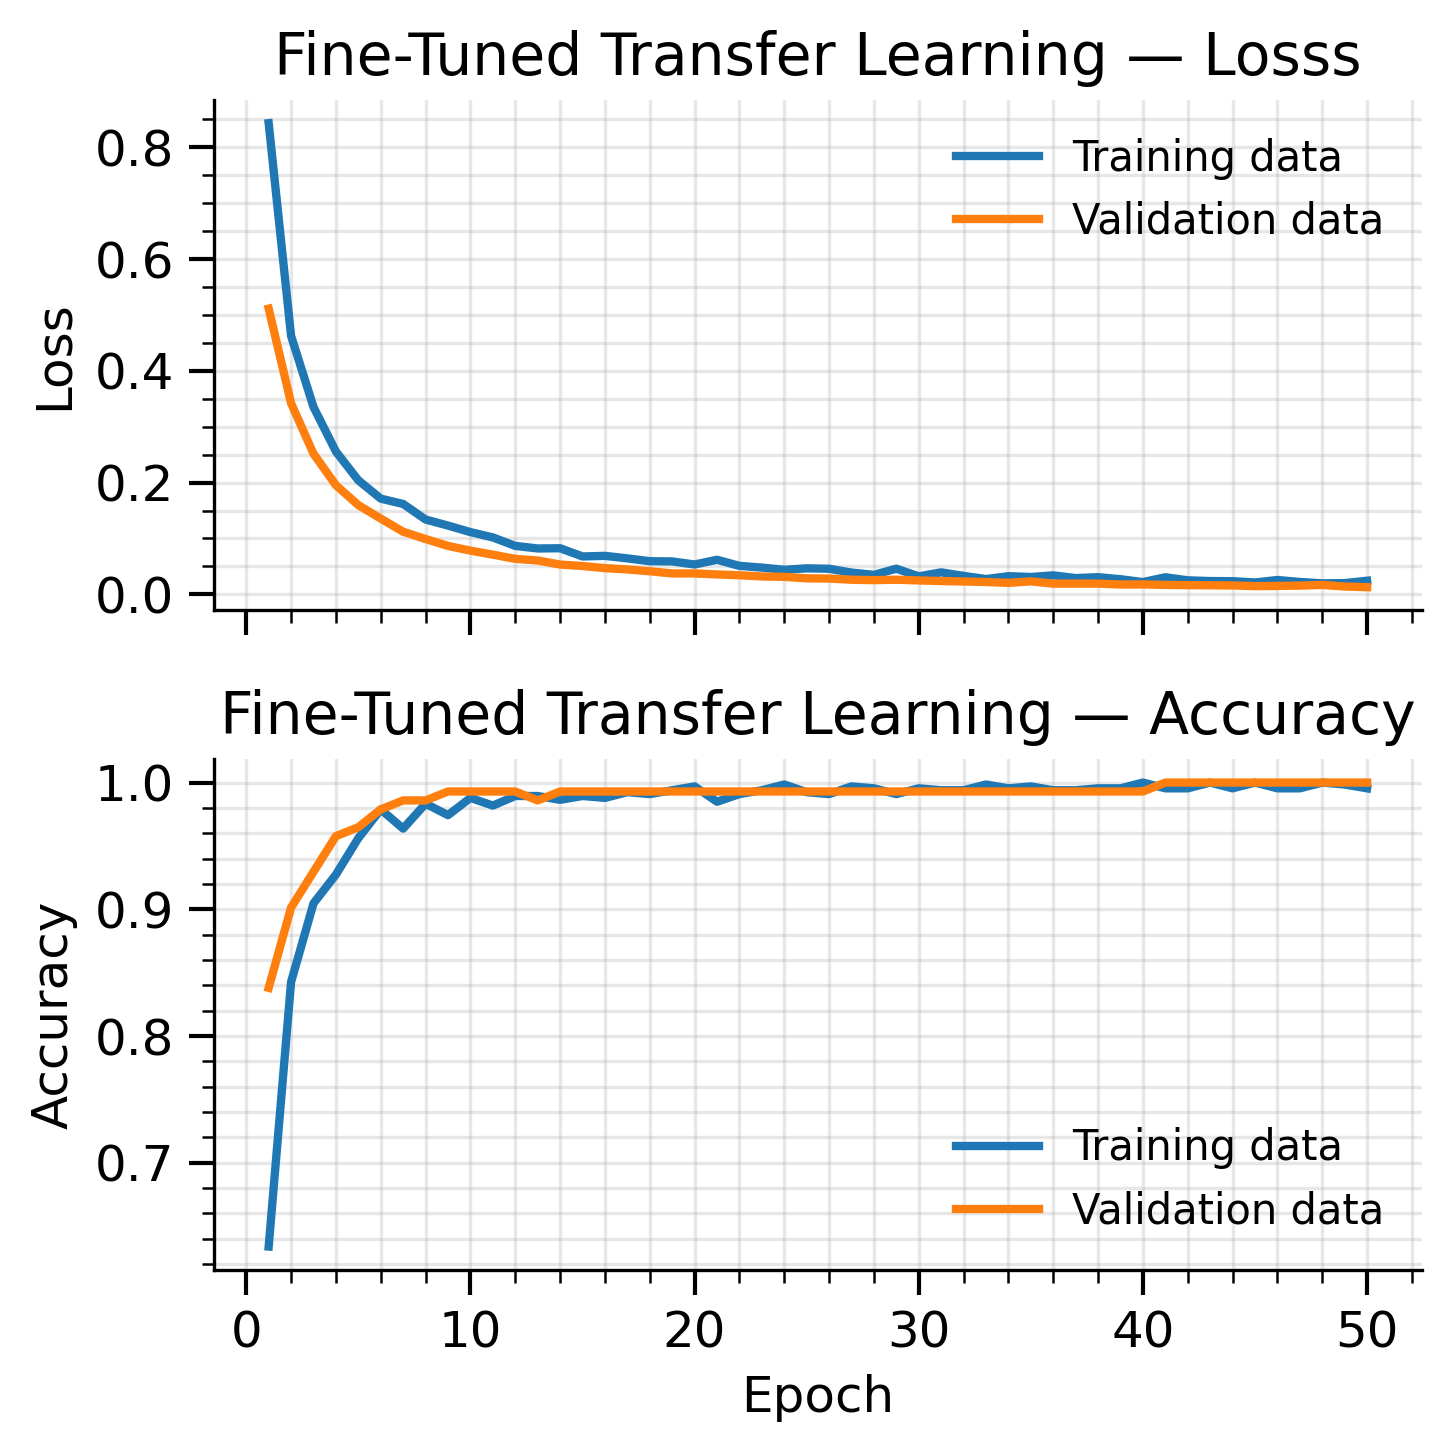

In [25]:
hist = history_tl.history
epochs = range(1, len(hist["loss"]) + 1)

acc_key = "accuracy" if "accuracy" in hist else "acc"
val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"


fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True)


axes[0].plot(epochs, hist["loss"], label="Training data")
axes[0].plot(epochs, hist["val_loss"], label="Validation data")
finalize_axes(axes[0], ylabel="Loss", title="Fine-Tuned Transfer Learning — Losss")

axes[1].plot(epochs, hist[acc_key], label="Training data")
axes[1].plot(epochs, hist[val_acc_key], label="Validation data")
finalize_axes(axes[1], ylabel="Accuracy", title="Fine-Tuned Transfer Learning — Accuracy", xlabel="Epoch")

plt.tight_layout()
fig.savefig("finetuned_combined.pdf", bbox_inches="tight")
plt.show()


## Evaluation of Fine-Tuned EfficientNetV2-B0 Model



Test Accuracy: 1.000
Test Loss: 0.009

Classification Report:

              precision    recall  f1-score   support

      Corona      1.000     1.000     1.000        46
     Surface      1.000     1.000     1.000        48
    Internal      1.000     1.000     1.000        48

    accuracy                          1.000       142
   macro avg      1.000     1.000     1.000       142
weighted avg      1.000     1.000     1.000       142



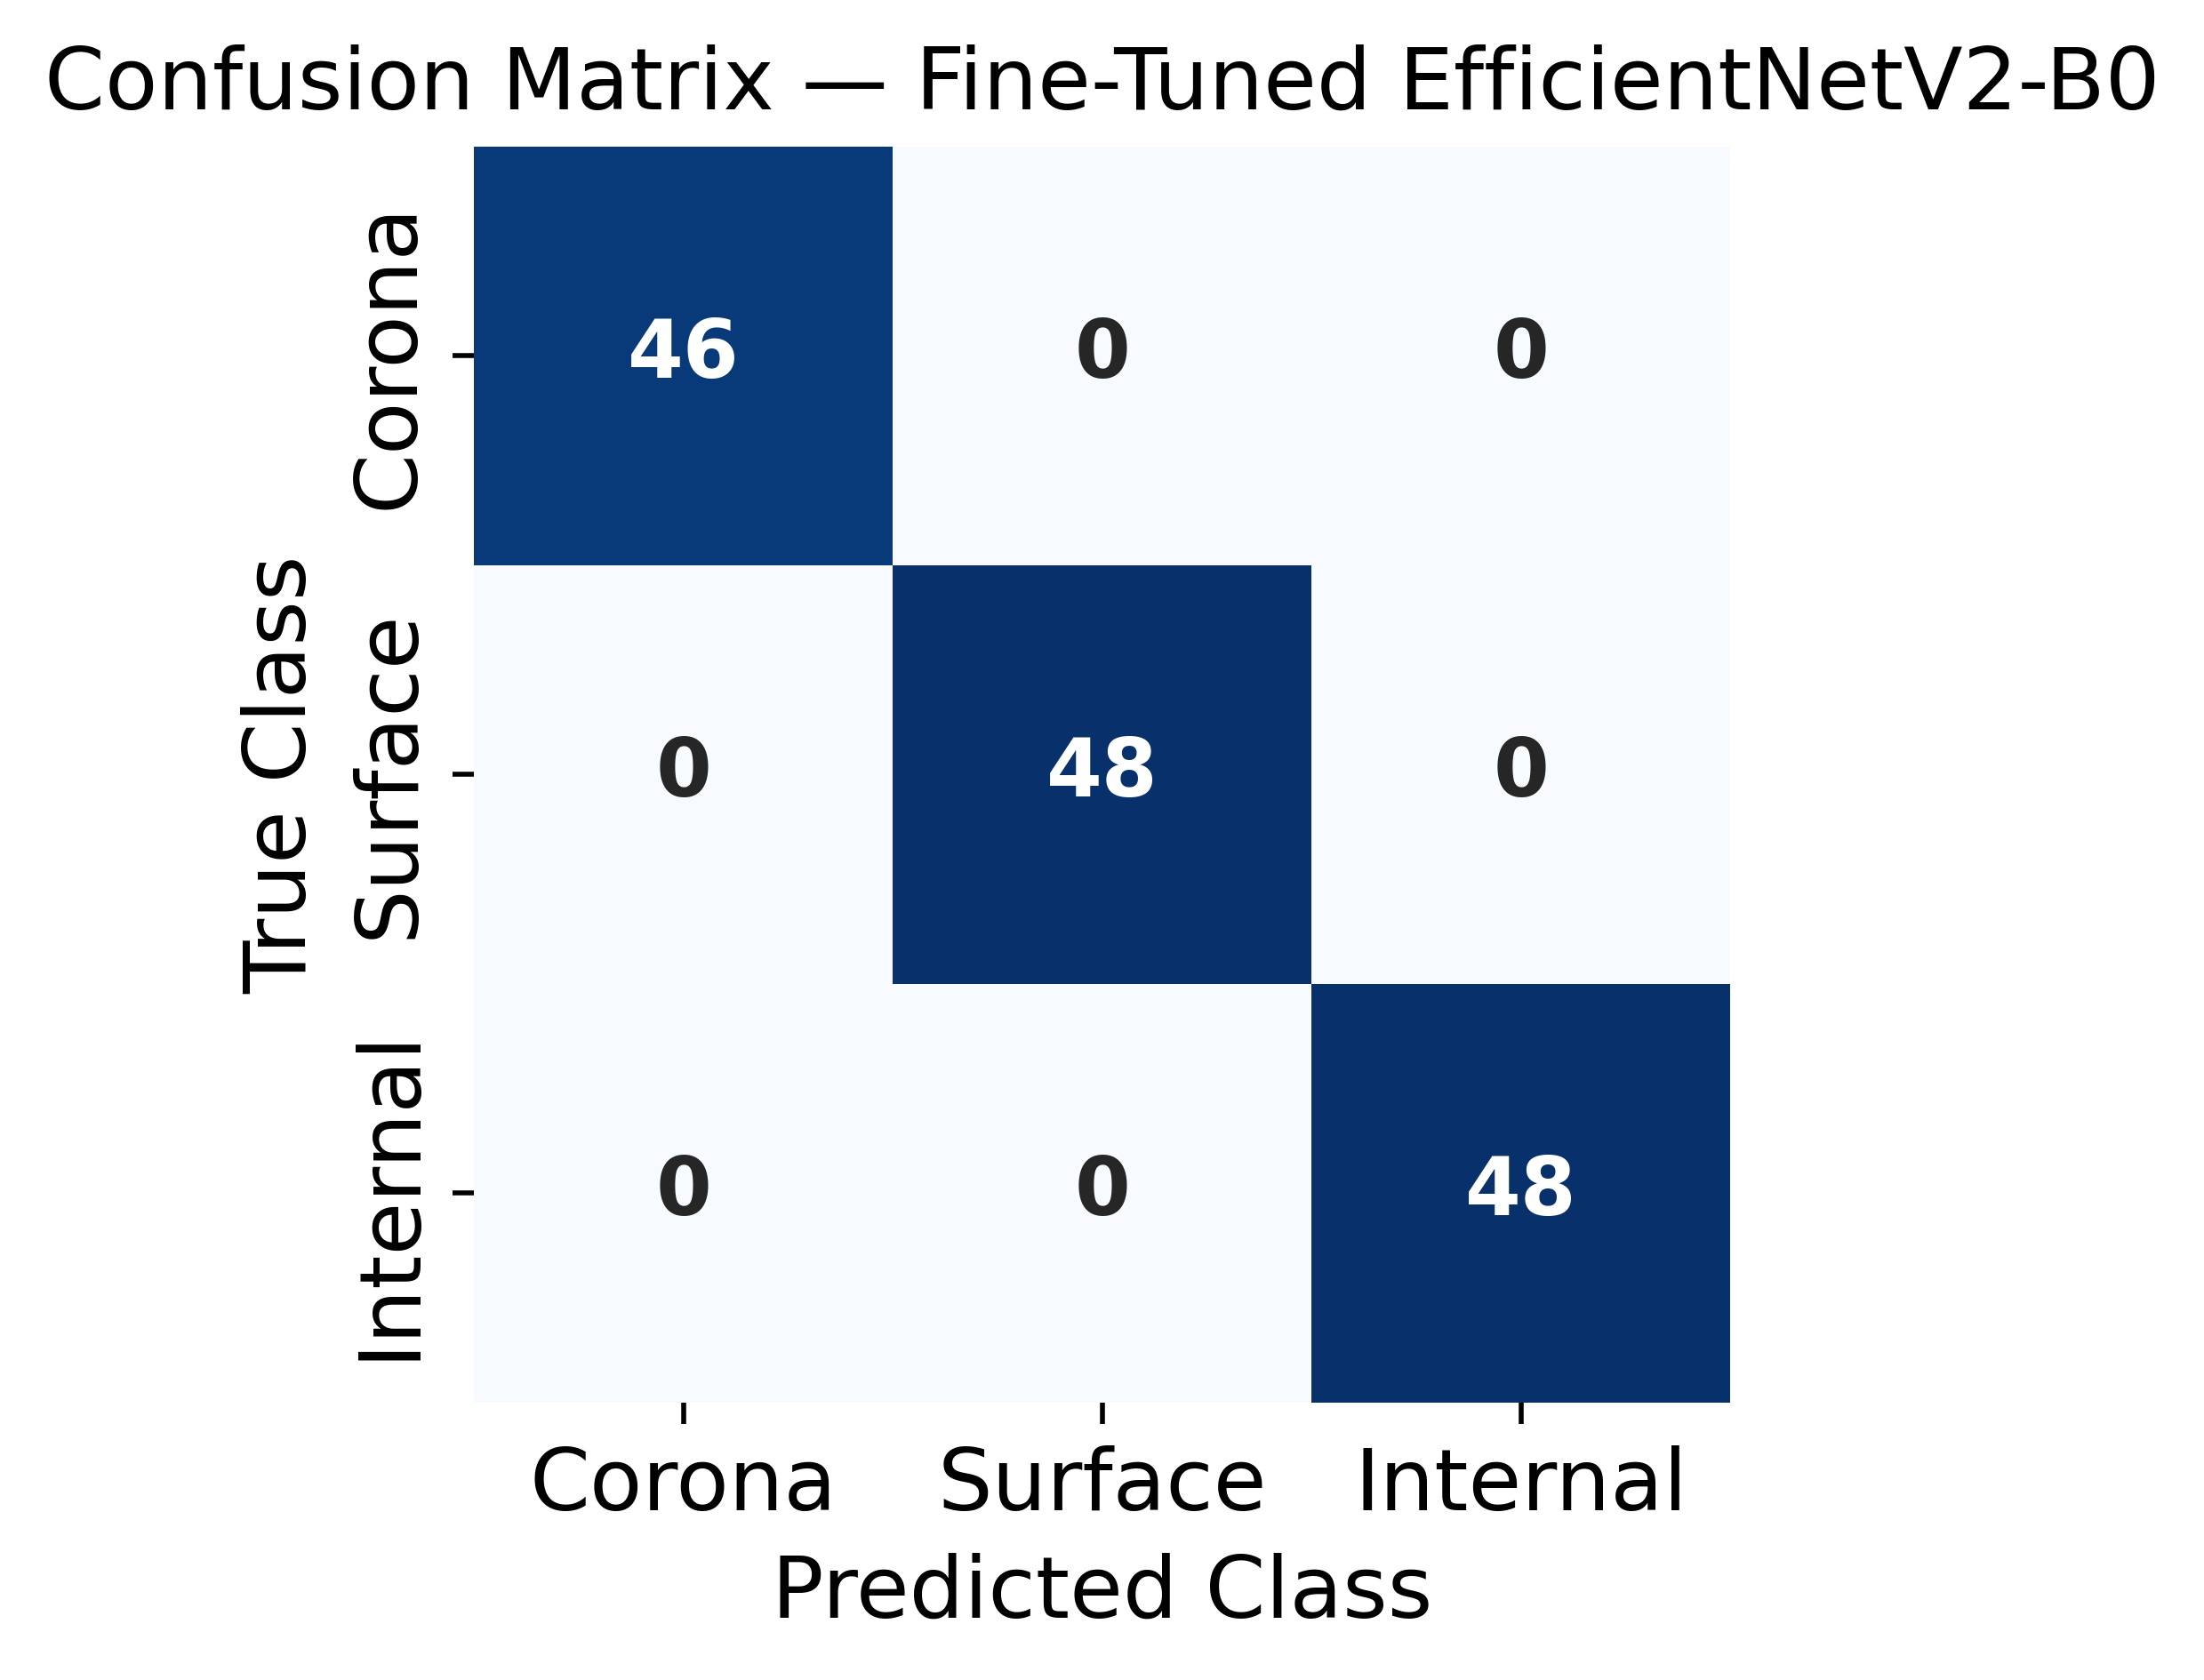

In [26]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

test_loss, test_acc = model_tl.evaluate(test_ds, verbose=0)
print(f"\nTest Accuracy: {test_acc:.3f}")
print(f"Test Loss: {test_loss:.3f}")
y_true = np.concatenate([y for _, y in test_ds], axis=0)
y_prob = model_tl.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
class_names = ["Corona", "Surface", "Internal"]
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 14,
    "axes.labelsize": 14,
    "figure.dpi": 500,
})
fig, ax = plt.subplots(figsize=(4.5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",  # 'd' = integer formatting for counts
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=False,
    square=True,
    annot_kws={"size": 13, "fontweight": "bold"},
    ax=ax
)

ax.set_xlabel("Predicted Class")
ax.set_ylabel("True Class")
ax.set_title("Confusion Matrix — Fine-Tuned EfficientNetV2-B0")
plt.tight_layout()

fig.savefig("confusion_matrix_finetuned.pdf", bbox_inches="tight")
plt.show()

# Visualization for Fine-Tuned EfficientNetV2-B0 Model

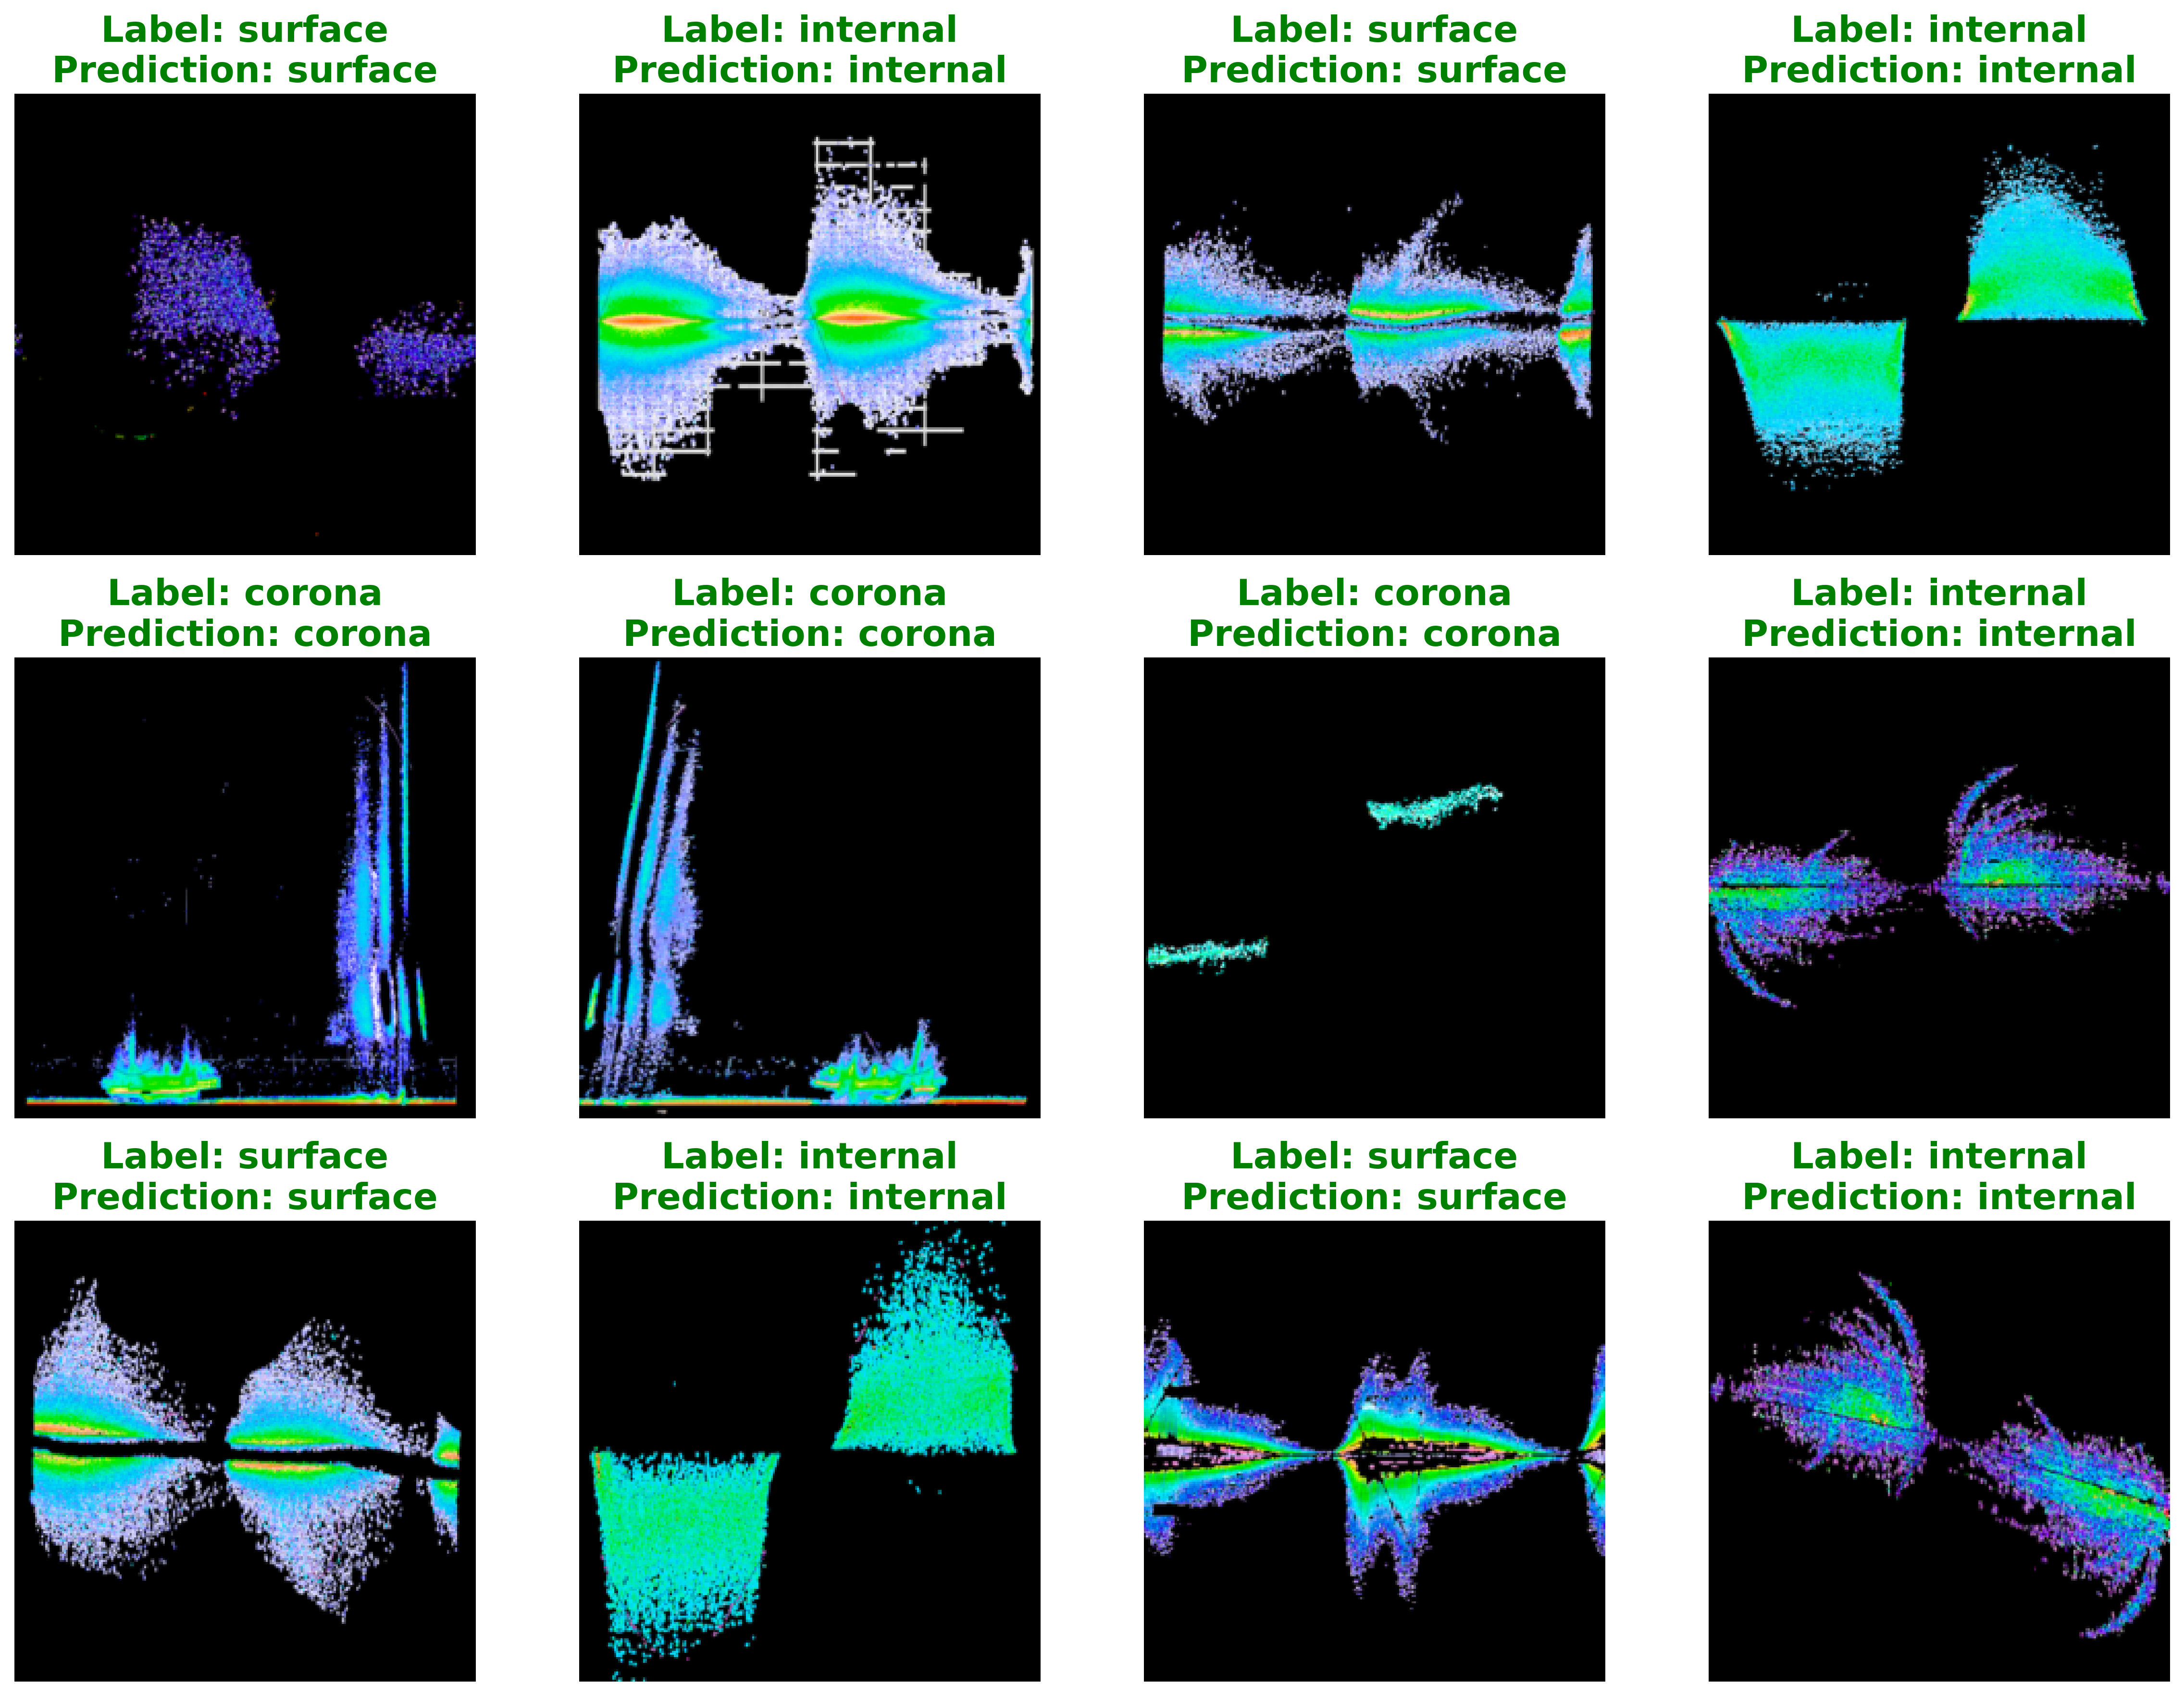

In [37]:
import matplotlib.pyplot as plt
import math
import numpy as np

sample_imgs, sample_lbls = next(iter(test_ds.unbatch().batch(12)))
probs = model_tl.predict(sample_imgs, verbose=0)
pred_ids = np.argmax(probs, axis=1)
conf = np.max(probs, axis=1)

cols, rows = 4, 3
n = sample_imgs.shape[0]

plt.rcParams.update({
    "font.size": 16,
    "axes.titlesize": 20,
    "figure.dpi": 300,
})

plt.figure(figsize=(cols * 4.0, rows * 4.0))

for i in range(n):
    ax = plt.subplot(rows, cols, i + 1)
    img = sample_imgs[i].numpy().astype(np.uint8)
    true_id = int(sample_lbls[i].numpy())
    pred_id = int(pred_ids[i])
    p_conf = float(conf[i])
    true_label = id_to_label[true_id]
    pred_label = id_to_label[pred_id]
    correct = (true_id == pred_id)
    title_color = "green" if correct else "red"

    ax.imshow(img)
    ax.set_title(
        f"Label: {true_label}\nPrediction: {pred_label}",
        color=title_color,
        fontsize=18,
        weight="bold"
    )

    for spine in ax.spines.values():
        spine.set_edgecolor(title_color)
        spine.set_linewidth(2.5)

    ax.axis("off")

plt.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.8)

plt.savefig("fine_tuned_predictions.pdf", bbox_inches="tight")
plt.show()


# Extra experiments
Rerunning some experiments using only real images as test data and only augmented as train/val. Due to the very high ratio of augmented/real images, we are interested in analyzing if this impacts performance significantly.

In [ ]:
from pathlib import Path
from collections import Counter
import shutil

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

RAW_DIR = Path("/content/pd_raw")   # path where dataset was extracted
TEST_REAL_DIR = Path("/content/pd_test_real")  # new folder for clean test data

TEST_REAL_DIR.mkdir(parents=True, exist_ok=True)

real_sim_imgs = []
for p in RAW_DIR.rglob("*"):
    if p.is_file() and p.suffix.lower() in IMG_EXTS:
        fname = p.name.lower()
        # Keep only real or simulated images, ignore generated ones
        if ("real" in fname or "sim" in fname) and "gen" not in fname:
            lbl = find_label_from_path(p.parent)
            if lbl is not None:
                real_sim_imgs.append((p, lbl))

print(f"Found {len(real_sim_imgs)} real/simulated images.")
print("Per-class counts:", Counter(lbl for _, lbl in real_sim_imgs))


Found 47 real/simulated images.
Per-class counts: Counter({'internal': 22, 'surface': 16, 'corona': 9})


In [ ]:
for src, lbl in real_sim_imgs:
    dest_dir = TEST_REAL_DIR / lbl
    dest_dir.mkdir(parents=True, exist_ok=True)
    shutil.copy(src, dest_dir)
